In this document we transform Parameter 5~10 to categorical variables and implement target mean encoding and weighted average encoding to see the effect. Here the labels are treated as oridinal varibales.

In order to train the model, we don't want highly linearly correlated variables so we apply PCA after the encodings.

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss, accuracy_score
import time
import seaborn as sns
from transforms import *

import warnings
warnings.filterwarnings("ignore")

from multiprocessing import Pool

import matplotlib.pyplot as plt

pca = PCA()

In [2]:
# read in data
training = pd.read_csv('first_round_training_data.csv')
testing = pd.read_csv('first_round_testing_data.csv')
features = ["Parameter5","Parameter6","Parameter7","Parameter8","Parameter9","Parameter10"]

training[features] = np.log(training[features].values)/np.log(10)
testing[features] = np.log(testing[features].values)/np.log(10)

In [3]:
code = {'Pass':1, 'Good':2, 'Excellent':3, 'Fail':0}
training['new_Quality'] = training['Quality_label'].apply(lambda x : code[x])

In [4]:
N = 10

skf = StratifiedKFold(n_splits=N)
indices = []
for train_index, test_index in skf.split(training[features], training[['new_Quality']]):
    indices.append([train_index, test_index])

In [5]:
train_cat, test_cat, new_features = all_to_category(training, testing, features)

In [6]:
train_cat.loc[:10, new_features]

,Parameter5_Categorical,Parameter6_Categorical,Parameter7_Categorical,Parameter8_Categorical,Parameter9_Categorical,Parameter10_Categorical
0,1,1,1,1,1,1
1,2,2,1,1,1,1
2,2,3,1,1,1,1
3,2,2,1,1,1,1
4,2,2,1,1,1,1
5,3,4,1,1,1,1
6,4,5,2,2,2,2
7,5,6,2,2,2,2
8,5,7,2,2,2,2
9,6,8,2,2,2,2


In [7]:
test_cat.loc[:10, new_features]

,Parameter5_Categorical,Parameter6_Categorical,Parameter7_Categorical,Parameter8_Categorical,Parameter9_Categorical,Parameter10_Categorical
0,5,11,5,5,9,12
1,69,22,2,4,6,14
2,69,22,2,4,6,14
3,103,6,5,2,2,2
4,60,5,5,2,2,2
5,60,5,5,2,2,2
6,34,5,5,2,2,2
7,34,5,5,2,2,2
8,60,44,5,2,2,2
9,60,5,5,2,2,2


In [8]:
codebook1 = target_mean_encoding_fit(training['Parameter5'], training['new_Quality'])
codebook2, counts = weighted_average_encoding_fit(training['Parameter5'], training['new_Quality'])
list(zip(target_mean_encoding_apply(training['Parameter5'], codebook1), 
    weighted_average_encoding_apply(training['Parameter5'], codebook2, counts, 10, 2)))[:10]

[(0.7142857142857143, 1.343856993072734),
 (1.2777777777777777, 1.2777782446603188),
 (1.2777777777777777, 1.2777782446603188),
 (1.2777777777777777, 1.2777782446603188),
 (1.2777777777777777, 1.2777782446603188),
 (1.4027777777777777, 1.4027777777777806),
 (1.691358024691358, 1.691358024691358),
 (1.7912087912087913, 1.7912087912087913),
 (1.7912087912087913, 1.7912087912087913),
 (1.7619047619047619, 1.7619047619047619)]

# No encoding

In [9]:
train = training[features + ['new_Quality']]
test = testing[features + ['Group']]
train, test = get_target_mean_encoding(train, test, features, 'new_Quality')
pca.fit(pd.concat([train[features], test[features]]))
np.cumsum(pca.explained_variance_ratio_)

array([0.5447735 , 0.7288468 , 0.8545898 , 0.92255694, 0.97117134,
       1.        ])

In [10]:
[np.var(train.iloc[:, i]) for i in range(6)]

[0.0693119650739107,
 0.05446256819190691,
 0.05041733881204648,
 0.06715716851667794,
 0.06105080765851163,
 0.07150669103829124]

In [11]:
train[:10]

,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,new_Quality
0,0.714286,1.000000,1.360000,1.301518,1.368514,1.444444,1
1,1.277778,1.415094,1.360000,1.301518,1.368514,1.444444,0
2,1.277778,1.418182,1.360000,1.301518,1.368514,1.444444,0
3,1.277778,1.415094,1.360000,1.301518,1.368514,1.444444,0
4,1.277778,1.415094,1.360000,1.301518,1.368514,1.444444,0
5,1.402778,1.363636,1.360000,1.301518,1.368514,1.444444,2
6,1.691358,1.476744,1.791259,1.814165,1.431075,1.365079,2
7,1.791209,1.847826,1.791259,1.814165,1.431075,1.365079,2
8,1.791209,1.138462,1.791259,1.814165,1.431075,1.365079,1
9,1.761905,1.346939,1.791259,1.814165,1.431075,1.365079,2


In [12]:
test[:10]

,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,Group
0,1.791209,1.816667,1.670707,1.691781,1.836601,1.779891,0
1,0.500000,1.206897,1.791259,1.012270,0.963576,1.580000,0
2,0.500000,1.206897,1.791259,1.012270,0.963576,1.580000,0
3,1.588235,1.847826,1.670707,1.814165,1.431075,1.365079,0
4,1.521739,1.476744,1.670707,1.814165,1.431075,1.365079,0
5,1.521739,1.476744,1.670707,1.814165,1.431075,1.365079,0
6,1.792453,1.476744,1.670707,1.814165,1.431075,1.365079,0
7,1.792453,1.476744,1.670707,1.814165,1.431075,1.365079,0
8,1.521739,1.875000,1.670707,1.814165,1.431075,1.365079,0
9,1.521739,1.476744,1.670707,1.814165,1.431075,1.365079,0


In [13]:
new_values = pca.fit_transform(pd.concat([train[features], test[features]]))
train[features] = new_values[:6000, :].copy()
test[features] = new_values[6000:, :].copy()

In [14]:
train.loc[:10, features]

,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10
0,0.673263,-0.440301,-0.497430,-0.048676,-0.072782,-0.007401
1,0.313121,-0.096937,-0.016830,-0.076517,0.025720,0.020377
2,0.312040,-0.096153,-0.015816,-0.079024,0.026379,0.020426
3,0.313121,-0.096937,-0.016830,-0.076517,0.025720,0.020377
4,0.313121,-0.096937,-0.016830,-0.076517,0.025720,0.020377
5,0.283493,-0.057207,0.042665,0.033869,0.016954,0.024265
6,-0.317406,0.211716,-0.093561,0.100128,-0.294145,-0.019855
7,-0.485408,0.348091,0.089265,-0.146415,-0.213228,-0.010219
8,-0.237010,0.168010,-0.143585,0.429631,-0.364534,-0.021457
9,-0.298842,0.208559,-0.093060,0.244253,-0.320585,-0.019257


In [15]:
test.loc[:10, features]

,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10
0,-0.664160,-0.074525,0.157894,-0.037026,0.157451,0.038423
1,0.785557,-0.564465,-0.360272,-0.434168,-0.480774,0.415473
2,0.785557,-0.564465,-0.360272,-0.434168,-0.480774,0.415473
3,-0.356665,0.259188,-0.001974,-0.252611,-0.153289,-0.099984
4,-0.201377,0.136900,-0.164417,0.012237,-0.233616,-0.108365
5,-0.201377,0.136900,-0.164417,0.012237,-0.233616,-0.108365
6,-0.304566,0.251234,0.001013,0.160802,-0.228829,-0.098179
7,-0.304566,0.251234,0.001013,0.160802,-0.228829,-0.098179
8,-0.340834,0.238002,-0.033689,-0.311170,-0.148669,-0.102056
9,-0.201377,0.136900,-0.164417,0.012237,-0.233616,-0.108365


# Target mean encoding

In [16]:
train_all, test_all, new_features = get_all_encoding(training, testing, features)
pca.fit(pd.concat([train_all[new_features], test_all[new_features]]))
np.cumsum(pca.explained_variance_ratio_)
#9 -> 91%, 11 -> 95%, 15 -> 98.9%  

array([0.37566689, 0.5479472 , 0.65765164, 0.73318998, 0.78424223,
       0.82559878, 0.86259956, 0.88985055, 0.91310452, 0.93577897,
       0.95042054, 0.96169343, 0.97220764, 0.98199181, 0.98941491,
       0.9951319 , 0.99844562, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

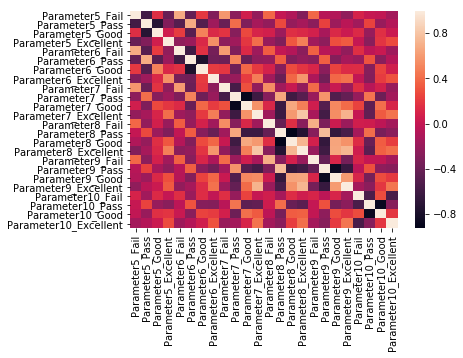

In [17]:
corr = train_all[new_features].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns)

In [18]:
new_values = pca.fit_transform(pd.concat([train_all[new_features], test_all[new_features]]))
train_all[new_features] = new_values[:6000, :].copy()
test_all[new_features] = new_values[6000:, :].copy()

In [19]:
train_all.loc[:10, new_features]

,Parameter5_Fail,Parameter5_Pass,Parameter5_Good,Parameter5_Excellent,Parameter6_Fail,Parameter6_Pass,Parameter6_Good,Parameter6_Excellent,Parameter7_Fail,Parameter7_Pass,...,Parameter8_Good,Parameter8_Excellent,Parameter9_Fail,Parameter9_Pass,Parameter9_Good,Parameter9_Excellent,Parameter10_Fail,Parameter10_Pass,Parameter10_Good,Parameter10_Excellent
0,0.264715,-0.031467,-0.001334,0.388546,-0.249962,0.002104,0.134471,-0.015529,-0.049152,-0.086362,...,-0.044675,0.014233,-0.001926,0.042954,8.241840e-16,-9.619826e-16,-9.947686e-16,-1.899404e-16,-3.989180e-16,4.923700e-16
1,-0.038449,0.379875,0.040719,-0.052844,-0.095879,-0.058010,0.053819,0.006558,-0.080521,0.080734,...,-0.020272,0.036992,-0.009286,0.023412,1.596518e-17,2.615466e-15,-3.169879e-16,6.113630e-16,-7.645238e-16,-2.373837e-16
2,-0.029499,0.364824,0.039871,-0.044083,-0.095811,-0.057206,0.031543,0.001053,-0.070960,0.066952,...,-0.022200,0.051339,-0.014036,0.021552,-5.673081e-16,9.510836e-16,-4.630560e-16,-4.649320e-16,-2.647510e-16,-7.327549e-16
3,-0.038449,0.379875,0.040719,-0.052844,-0.095879,-0.058010,0.053819,0.006558,-0.080521,0.080734,...,-0.020272,0.036992,-0.009286,0.023412,2.319987e-17,-4.161270e-16,1.524025e-16,2.452938e-16,-3.173059e-16,1.376691e-17
4,-0.038449,0.379875,0.040719,-0.052844,-0.095879,-0.058010,0.053819,0.006558,-0.080521,0.080734,...,-0.020272,0.036992,-0.009286,0.023412,4.331548e-16,-3.738079e-17,-1.807320e-16,4.198221e-16,-3.907504e-16,1.009913e-16
5,-0.016906,0.318185,0.047543,-0.041942,-0.091968,-0.068039,0.113058,0.027087,-0.018586,0.051510,...,-0.018127,0.025393,-0.007213,0.025202,-4.310955e-16,7.175704e-16,-6.342865e-16,-3.904152e-16,2.343691e-16,7.520582e-16
6,-0.361943,0.022123,0.309627,0.015036,-0.025253,-0.117757,-0.044740,0.174055,-0.090500,-0.057619,...,0.081214,-0.083915,0.029255,-0.001770,2.821259e-16,4.934707e-17,-3.844687e-16,4.072601e-18,-2.998463e-16,8.426656e-17
7,-0.409347,0.041057,0.324228,-0.091823,0.032154,-0.134082,-0.108997,0.185759,-0.055808,-0.038417,...,0.074889,-0.055872,0.017014,-0.011948,1.035123e-16,-3.980113e-16,3.870439e-16,-1.239460e-16,-5.041012e-16,4.555454e-17
8,-0.406429,0.141882,0.296762,0.000593,-0.033078,-0.100581,-0.121853,0.124047,-0.050595,-0.197377,...,0.090660,-0.037795,0.021442,0.002203,3.880259e-16,-8.505203e-17,-6.674761e-16,-6.218499e-16,-3.701996e-17,-2.817431e-16
9,-0.358249,0.020338,0.307319,0.025585,-0.028437,-0.114840,-0.047267,0.167295,-0.041180,-0.127823,...,0.084770,-0.087630,0.031602,0.003571,6.848307e-16,-5.750586e-17,1.997056e-17,-4.115753e-16,-2.384575e-16,-2.827081e-16


In [20]:
test_all.loc[:10, new_features]

,Parameter5_Fail,Parameter5_Pass,Parameter5_Good,Parameter5_Excellent,Parameter6_Fail,Parameter6_Pass,Parameter6_Good,Parameter6_Excellent,Parameter7_Fail,Parameter7_Pass,...,Parameter8_Good,Parameter8_Excellent,Parameter9_Fail,Parameter9_Pass,Parameter9_Good,Parameter9_Excellent,Parameter10_Fail,Parameter10_Pass,Parameter10_Good,Parameter10_Excellent
0,-0.454796,-0.007427,-0.280158,-0.217925,-0.024515,-0.083825,-0.055619,0.008569,0.026544,0.033692,...,-0.025624,0.075336,-0.027688,0.031350,1.093005e-16,-2.542976e-17,-4.655453e-18,1.544487e-17,1.693924e-17,-2.169563e-18
1,-0.248347,0.433323,-0.263929,0.261588,-0.104816,0.206304,-0.028583,-0.009194,-0.084489,-0.079181,...,0.130703,0.096389,0.027013,-0.030489,1.621515e-16,-1.553067e-17,9.642530e-18,1.205399e-18,-4.064425e-18,-1.390112e-17
2,-0.248347,0.433323,-0.263929,0.261588,-0.104816,0.206304,-0.028583,-0.009194,-0.084489,-0.079181,...,0.130703,0.096389,0.027013,-0.030489,1.621515e-16,-1.553067e-17,9.642530e-18,1.205399e-18,-4.064425e-18,-1.390112e-17
3,-0.437352,0.098414,0.304001,-0.025625,-0.022403,-0.151050,-0.113592,0.177689,-0.076387,-0.034937,...,0.018689,-0.025846,-0.014447,0.035672,1.507843e-16,-1.429066e-17,3.800626e-17,-1.917869e-18,-2.283806e-17,3.626646e-17
4,-0.414393,0.127274,0.290707,0.048288,-0.069854,-0.140775,-0.104589,0.156154,-0.134385,-0.021214,...,0.028153,-0.051453,-0.003216,0.043788,1.361274e-16,3.393012e-18,2.309722e-17,-3.920413e-17,-3.093306e-17,1.068142e-17
5,-0.414393,0.127274,0.290707,0.048288,-0.069854,-0.140775,-0.104589,0.156154,-0.134385,-0.021214,...,0.028153,-0.051453,-0.003216,0.043788,1.361274e-16,3.393012e-18,2.309722e-17,-3.920413e-17,-3.093306e-17,1.068142e-17
6,-0.449717,0.150573,0.301683,-0.028782,-0.027407,-0.160085,-0.176098,0.155780,-0.033120,-0.085845,...,0.035055,-0.056196,-0.003638,0.046038,1.294611e-16,-2.227716e-18,1.593341e-17,-1.626001e-17,-2.273014e-18,4.759360e-18
7,-0.449717,0.150573,0.301683,-0.028782,-0.027407,-0.160085,-0.176098,0.155780,-0.033120,-0.085845,...,0.035055,-0.056196,-0.003638,0.046038,1.294611e-16,-2.227716e-18,1.593341e-17,-1.626001e-17,-2.273014e-18,4.759360e-18
8,-0.495279,0.191209,0.304533,-0.068275,-0.028306,-0.139079,0.063910,0.202692,-0.130689,-0.008017,...,0.021716,-0.029932,-0.008312,0.035653,1.318429e-16,-3.291853e-17,1.664220e-17,-3.289079e-19,-4.656830e-17,2.065409e-19
9,-0.414393,0.127274,0.290707,0.048288,-0.069854,-0.140775,-0.104589,0.156154,-0.134385,-0.021214,...,0.028153,-0.051453,-0.003216,0.043788,1.427180e-16,1.555394e-17,2.158122e-17,-3.890082e-17,-2.353847e-17,1.138852e-17


# Weight of Evidence (WoE)

In [21]:
train_woe, test_woe, new_features = get_all_WoE(training, testing, features)
pca.fit(pd.concat([train_woe[new_features], test_woe[new_features]]))
np.cumsum(pca.explained_variance_ratio_)
#10 -> 91%, 13 -> 95.8%  17 -> 98.9%

array([0.30416395, 0.50363393, 0.61888416, 0.70855369, 0.76294365,
       0.80089755, 0.83461254, 0.86443958, 0.88752588, 0.9101481 ,
       0.93094329, 0.94602179, 0.95859352, 0.96938257, 0.9792597 ,
       0.98544015, 0.98906531, 0.99154925, 0.99388166, 0.99583505,
       0.99748494, 0.99895261, 0.99958115, 1.        ])

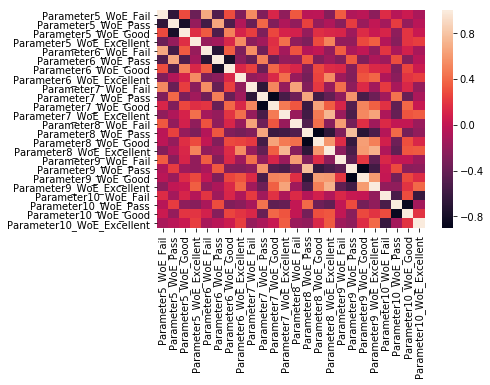

In [22]:
corr = train_woe[new_features].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns)

In [23]:
train_woe.loc[:10, new_features]

,Parameter5_WoE_Fail,Parameter5_WoE_Pass,Parameter5_WoE_Good,Parameter5_WoE_Excellent,Parameter6_WoE_Fail,Parameter6_WoE_Pass,Parameter6_WoE_Good,Parameter6_WoE_Excellent,Parameter7_WoE_Fail,Parameter7_WoE_Pass,...,Parameter8_WoE_Good,Parameter8_WoE_Excellent,Parameter9_WoE_Fail,Parameter9_WoE_Pass,Parameter9_WoE_Good,Parameter9_WoE_Excellent,Parameter10_WoE_Fail,Parameter10_WoE_Pass,Parameter10_WoE_Good,Parameter10_WoE_Excellent
0,-0.956640,-1.182131,1.682769,1.221898,-0.646485,-0.594344,0.073331,1.458287,-0.416562,0.254928,...,0.223253,0.552838,0.133951,-0.409905,0.203708,0.350580,-0.086004,-0.053213,0.057887,0.048421
1,-0.819328,0.669221,-0.585914,0.772631,-0.683526,0.874173,-0.568924,0.289347,-0.416562,0.254928,...,0.223253,0.552838,0.133951,-0.409905,0.203708,0.350580,-0.086004,-0.053213,0.057887,0.048421
2,-0.819328,0.669221,-0.585914,0.772631,-0.693552,0.753141,-0.398383,0.102009,-0.416562,0.254928,...,0.223253,0.552838,0.133951,-0.409905,0.203708,0.350580,-0.086004,-0.053213,0.057887,0.048421
3,-0.819328,0.669221,-0.585914,0.772631,-0.683526,0.874173,-0.568924,0.289347,-0.416562,0.254928,...,0.223253,0.552838,0.133951,-0.409905,0.203708,0.350580,-0.086004,-0.053213,0.057887,0.048421
4,-0.819328,0.669221,-0.585914,0.772631,-0.683526,0.874173,-0.568924,0.289347,-0.416562,0.254928,...,0.223253,0.552838,0.133951,-0.409905,0.203708,0.350580,-0.086004,-0.053213,0.057887,0.048421
5,-0.434152,0.351299,-0.342390,0.297639,-0.797716,0.868568,-0.607546,0.394161,-0.416562,0.254928,...,0.223253,0.552838,0.133951,-0.409905,0.203708,0.350580,-0.086004,-0.053213,0.057887,0.048421
6,0.193820,0.465338,-0.391377,-0.312504,-0.365971,0.431825,-0.306158,0.042705,0.110071,0.775734,...,-0.456265,-0.617444,0.591985,-0.599767,0.338557,0.186209,-0.845155,1.353236,-0.994028,0.878127
7,-0.068968,1.054925,-0.514455,-0.581247,0.500330,0.515182,-0.316133,-0.679061,0.110071,0.775734,...,-0.456265,-0.617444,0.591985,-0.599767,0.338557,0.186209,-0.845155,1.353236,-0.994028,0.878127
8,-0.068968,1.054925,-0.514455,-0.581247,-1.282474,0.625690,0.428672,0.069702,0.110071,0.775734,...,-0.456265,-0.617444,0.591985,-0.599767,0.338557,0.186209,-0.845155,1.353236,-0.994028,0.878127
9,0.239279,0.471745,-0.137022,-0.620734,-0.646485,0.406446,-0.225162,0.248449,0.110071,0.775734,...,-0.456265,-0.617444,0.591985,-0.599767,0.338557,0.186209,-0.845155,1.353236,-0.994028,0.878127


In [24]:
test_woe.loc[:10, new_features]

,Parameter5_WoE_Fail,Parameter5_WoE_Pass,Parameter5_WoE_Good,Parameter5_WoE_Excellent,Parameter6_WoE_Fail,Parameter6_WoE_Pass,Parameter6_WoE_Good,Parameter6_WoE_Excellent,Parameter7_WoE_Fail,Parameter7_WoE_Pass,...,Parameter8_WoE_Good,Parameter8_WoE_Excellent,Parameter9_WoE_Fail,Parameter9_WoE_Pass,Parameter9_WoE_Good,Parameter9_WoE_Excellent,Parameter10_WoE_Fail,Parameter10_WoE_Pass,Parameter10_WoE_Good,Parameter10_WoE_Excellent
0,-0.068968,1.054925,-0.514455,-0.581247,0.258894,0.697586,-0.336275,-0.644110,-0.272129,1.066060,...,-0.454462,-0.479593,0.020394,1.004841,-0.366035,-0.738938,1.381946,-0.241620,0.526725,-0.750009
1,-2.291641,0.795911,0.584157,1.881144,-0.975964,0.534313,-0.256148,0.538230,0.110071,0.775734,...,-0.037454,1.420428,-1.412019,0.556361,0.186574,0.989850,0.183864,-0.052082,0.261384,-0.367539
2,-2.291641,0.795911,0.584157,1.881144,-0.975964,0.534313,-0.256148,0.538230,0.110071,0.775734,...,-0.037454,1.420428,-1.412019,0.556361,0.186574,0.989850,0.183864,-0.052082,0.261384,-0.367539
3,-0.646485,1.027712,-0.454736,-0.387540,0.500330,0.515182,-0.316133,-0.679061,-0.272129,1.066060,...,-0.456265,-0.617444,0.591985,-0.599767,0.338557,0.186209,-0.845155,1.353236,-0.994028,0.878127
4,-0.532074,0.819349,-0.602424,-0.019815,-0.365971,0.431825,-0.306158,0.042705,-0.272129,1.066060,...,-0.456265,-0.617444,0.591985,-0.599767,0.338557,0.186209,-0.845155,1.353236,-0.994028,0.878127
5,-0.532074,0.819349,-0.602424,-0.019815,-0.365971,0.431825,-0.306158,0.042705,-0.272129,1.066060,...,-0.456265,-0.617444,0.591985,-0.599767,0.338557,0.186209,-0.845155,1.353236,-0.994028,0.878127
6,-0.437940,1.595254,-0.454736,-0.751041,-0.365971,0.431825,-0.306158,0.042705,-0.272129,1.066060,...,-0.456265,-0.617444,0.591985,-0.599767,0.338557,0.186209,-0.845155,1.353236,-0.994028,0.878127
7,-0.437940,1.595254,-0.454736,-0.751041,-0.365971,0.431825,-0.306158,0.042705,-0.272129,1.066060,...,-0.456265,-0.617444,0.591985,-0.599767,0.338557,0.186209,-0.845155,1.353236,-0.994028,0.878127
8,-0.532074,0.819349,-0.602424,-0.019815,-0.183861,1.674340,-0.695802,-0.715447,-0.272129,1.066060,...,-0.456265,-0.617444,0.591985,-0.599767,0.338557,0.186209,-0.845155,1.353236,-0.994028,0.878127
9,-0.532074,0.819349,-0.602424,-0.019815,-0.365971,0.431825,-0.306158,0.042705,-0.272129,1.066060,...,-0.456265,-0.617444,0.591985,-0.599767,0.338557,0.186209,-0.845155,1.353236,-0.994028,0.878127


In [25]:
new_values = pca.fit_transform(pd.concat([train_woe[new_features], test_woe[new_features]]))
train_woe[new_features] = new_values[:6000, :].copy()
test_woe[new_features] = new_values[6000:, :].copy()

## Tuning parameters

See codes in my_GridSearch.py